In [1]:
#################################
#       Loading Packages        #
#################################

import packages##
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import glob

In [2]:
###################################
#        Imporing Data            #
###################################

#define path
path=r"/Users/valeriyamalenko/Desktop/trading/trading/momentum/data/mecklai-finance/"

#list paths to all usd-base files
files=glob.glob(path +"/usd-*.csv")

#open the first file
tb1=pd.read_csv(files[0])

#append all other files in the directory to the first file
for i in files[1:]:
    tb2=pd.read_csv(i, header=0)
    tb1=tb1.append(tb2)
    
tb2=tb2[['Currency', 'Date', 'SpotDate', 'SpotRate', 'col1']]
tb2=tb2.drop_duplicates()
tb2=tb2.reset_index()
tb2.drop('index', inplace=True, axis='columns')

In [ ]:
#list paths to usd-term files
files=glob.glob(path +"/*-usd.csv")

#open the first file
tb=pd.read_csv(files[0])

#append all other files in the directory to the first file
for i in files[1:]:
    tb1=pd.read_csv(i, header=0)
    tb=tb.append(tb1)
    
tb=tb[['Currency', 'Date', 'SpotDate', 'SpotRate', 'col1']]
tb=tb.drop_duplicates()
tb=tb.reset_index()
tb.drop('index', inplace=True, axis='columns')


In [4]:
#transorming pairs to be quoted against the dollar (e.g. USD/GBP)
tb2.SpotRate=1/tb2.SpotRate
tb2.col1=1/tb2.col1

a=tb2.Currency.str.split("/")
tb2["Currency"]=a.str[1]+"/"+a.str[0]

In [906]:
#adding usd-term and usd-base dfs
frames=[tb,tb2]
df=pd.concat(frames)

In [907]:
#######################################
# cleaning and transforming the data #
#######################################

#convert date to datetime
df.Date=pd.to_datetime(df.Date)

#drop duplicates
ccy_l=df['Currency'].unique().tolist()
i=ccy_l[0]
df1=df[df['Currency']==i]
df1=df1.drop_duplicates(['Date'])

for i in ccy_l[1:]:
    df2=df[df['Currency']==i]
    df2=df2.drop_duplicates(['Date'])
    df1=df1.append(df2)
df=df1

#set date to be the index
df=df.set_index('Date')

#rename the column
df.rename(columns={'col1': 'fwd1m'}, inplace=True)

#delete missing data
df = df.loc[df["SpotRate"]!=0]
df = df.loc[df["fwd1m"]!=0]

#generate new cols for logs of spot and fwd rates
df['logSpotRate']=np.log(df.SpotRate)
df['logfwd1m']=np.log(df.fwd1m)

#select last day of the month for each month
df=df.loc[df.reset_index().groupby(df.index.to_period('M'))['Date'].max()]

#exclude data for 2019
dt = datetime.datetime(2019, 1, 1)
df=df[df.index < np.datetime64(dt)]

#checking the length (21*12*8 = 2016)
len(df)

2016

In [908]:
ccy_n=len(ccy_l)

#take a ccy data set
df1=df.loc[df['Currency']==ccy_l[0]]

#Below is included to suppress the warning
pd.options.mode.chained_assignment = None

#shift the fwd rate down
df1['shiftlogfwd1m']=df1.logfwd1m.shift(1)

#calculate return
df1['Returns']=df1['shiftlogfwd1m']-df1['logSpotRate']

#repeat this for all ccies
for i in ccy_l[1:]:
    tb=df.loc[df['Currency']==i]
    tb['shiftlogfwd1m']=tb.logfwd1m.shift(1)
    tb['Returns']=tb['shiftlogfwd1m']-tb['logSpotRate']
    
    #append all ccy dfs to form one df
    df1=df1.append(tb)

#generating final dataset
data=df1[['Currency', 'SpotDate', 'Returns']]
data=data.reset_index()

In [909]:
##visualising the data##

import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

#Close down warnings
plt.rcParams.update({'figure.max_open_warning': 0})

#plot data
#data.groupby('Currency').plot(x='Date', y='Returns');

In [910]:
#let's pivot the data such that we can see what each graph/line represents
pivot1=data.pivot(index='Date', columns='Currency', values='Returns')

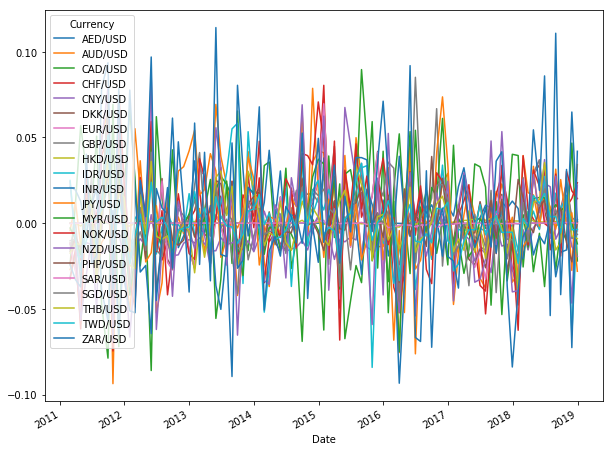

In [911]:
#let's also plot all currencies on one graph
pivot1.plot(figsize=(10,8));
#this is much better but the picture is too crowded
#from this we can see that some ccy's returns are more volatile than others
#returns are random and seem to move around zero

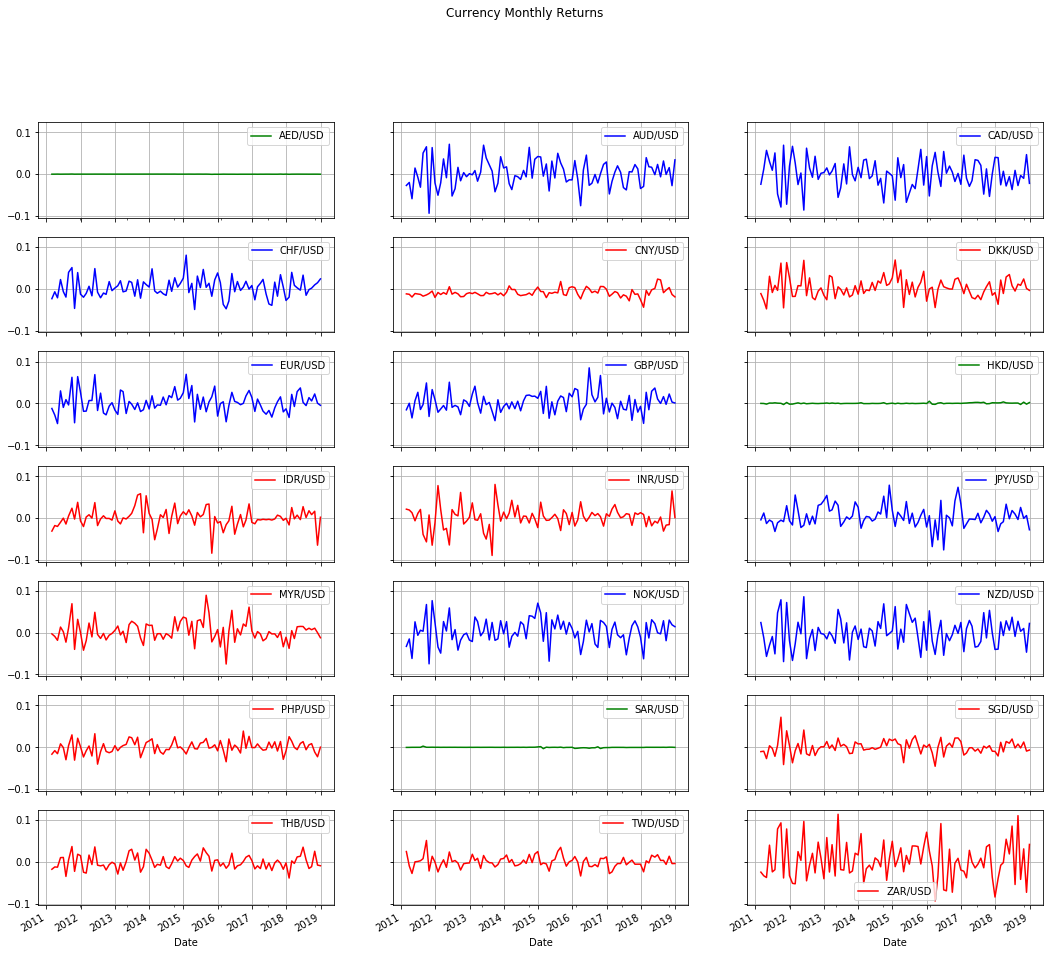

In [912]:
#let's make this plot less crowded and split currencies onto different axes
pivot1.plot(kind='line', subplots=True, grid=True, title="Currency Monthly Returns",
         sharex=True, sharey=True, legend=True, figsize=(18, 16), layout=(7,3),
        style=['g', 'b', 'b', 
               'b', 'r', 'r', 
               'b', 'b', 'g', 
               'r', 'r', 'b',
               'r', 'b', 'b', 
               'r', 'g', 'r',
               'r', 'r', 'r']);
#in blue are currencies that are in G9
#in green are currencies whose exchange rate is fixed to one degree or another
#usdzar stands out as a particularly volative pair throughout the years

In [913]:
#now, let's look at currency cumulative returns
#generate a cumulative returns column
#pivot1_cuml=pivot1.apply(lambda x: (x+1).prod() - 1)
pivot1_cuml=((1+pivot1).cumprod()-1)

In [914]:
pivot1_cuml

Currency,AED/USD,AUD/USD,CAD/USD,CHF/USD,CNY/USD,DKK/USD,EUR/USD,GBP/USD,HKD/USD,IDR/USD,...,JPY/USD,MYR/USD,NOK/USD,NZD/USD,PHP/USD,SAR/USD,SGD/USD,THB/USD,TWD/USD,ZAR/USD
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,-0.000109,-0.027137,-0.024186,-0.023742,-0.012242,-0.011594,-0.012138,-0.015331,0.000013,-0.031253,...,-0.004356,-0.002878,-0.032769,0.024186,-0.016447,-0.000240,-0.010316,-0.017487,0.024869,-0.024337
2011-03-31,-0.000191,-0.046554,-0.012157,-0.030850,-0.025311,-0.038823,-0.039692,-0.015026,-0.000193,-0.048670,...,0.007620,-0.011865,-0.047302,0.011561,-0.024226,-0.000427,-0.019534,-0.029260,0.015012,-0.056613
2011-04-29,-0.000109,-0.102714,0.043980,-0.051810,-0.044582,-0.085077,-0.086047,-0.049258,-0.001915,-0.067774,...,-0.005568,-0.029886,-0.106116,-0.045924,-0.039133,-0.000427,-0.046013,-0.041371,-0.012909,-0.091748
2011-05-31,-0.000245,-0.089656,0.075338,-0.030929,-0.055487,-0.057778,-0.058692,-0.043301,-0.001029,-0.077223,...,-0.010267,-0.016853,-0.082920,-0.074582,-0.031134,-0.000427,-0.042445,-0.031456,-0.012631,-0.055274
2011-06-30,-0.000299,-0.096374,0.085225,-0.037518,-0.067335,-0.066208,-0.067687,-0.017922,-0.000361,-0.077438,...,-0.019425,-0.014670,-0.088711,-0.083090,-0.031804,-0.000400,-0.044935,-0.021027,-0.011461,-0.077738
2011-07-28,-0.000299,-0.124636,0.140254,-0.056695,-0.079933,-0.058670,-0.059290,-0.032273,0.001025,-0.090677,...,-0.050961,-0.037044,-0.083439,-0.129585,-0.060609,-0.000373,-0.065519,-0.054915,-0.008571,-0.094804
2011-08-25,-0.000299,-0.080564,0.086167,-0.019690,-0.096240,-0.062377,-0.062756,-0.034817,0.001616,-0.086222,...,-0.061751,-0.026114,-0.080349,-0.088297,-0.056736,0.002429,-0.061254,-0.050346,-0.000785,-0.023336
2011-09-30,-0.000082,-0.020384,0.000604,0.029998,-0.109596,-0.004846,-0.004226,0.012366,0.001822,-0.064765,...,-0.066506,0.041349,-0.018432,-0.016478,-0.028688,0.002536,0.006353,-0.015279,0.050538,0.068018


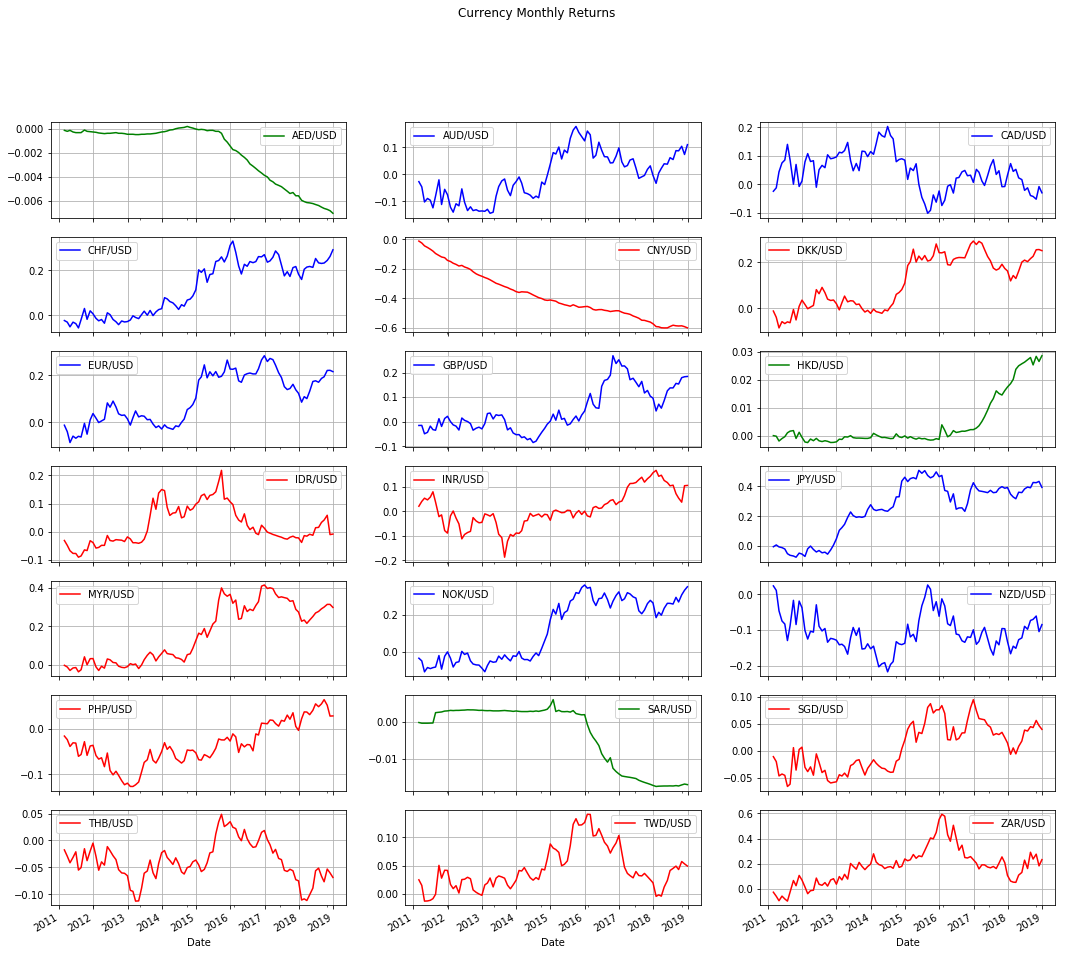

In [915]:
pivot1_cuml.plot(kind='line', subplots=True, grid=True, title="Currency Monthly Returns",
         sharex=True, sharey=False, legend=True, figsize=(18, 16), layout=(7,3),
        style=['g', 'b', 'b', 
               'b', 'r', 'r', 
               'b', 'b', 'g', 
               'r', 'r', 'b',
               'r', 'b', 'b', 
               'r', 'g', 'r',
               'r', 'r', 'r']);

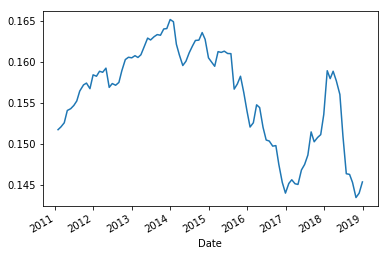

In [916]:
#Checking that what we have makes sense
df_1=df.reset_index().pivot(index='Date', columns='Currency', values='SpotRate')
df_1['CNY/USD'].plot()

In [917]:
## Portfolio Formulation -- defining rules
#Investment Universe: 21 currency pairs
#Trading frequency: monthly (also want to explore daily obvi)
#Position weights: equal
## Formation period of f=1,3,6,9,12
## h=1, 3, 6, 9, 12 month holding period
# so these are the currencies we want to play with
#Instead of 6 portfolios, I form 3 portfolios. 
#One third of all available currencies in a given month which have the lowest agged 
#return are allocated to the first portfolio.

In [918]:
#First momentum strategy
#f = 1
#h = 1
#assume I invest 700K long in 'high' portfolio and 700K short in 'low' portfolio (total 1.4M)
# each currency gets 10% of allocation
# for each index row sort returns from lowest to highest
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

## I want to change date format for easier shifts later
data['Year']=data.index.year
data['Month']=data.index.month
data.reset_index(drop=True, inplace=True)
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(Day=28))
data=data.set_index('Date')
data=data.loc[data.index !='2011-01-28']

In [919]:
df = pd.DataFrame()
for i in data.index.unique():
    new_tbl=data.loc[data.index==i]                         #for each month in the dataframe
    new_tbl.sort_values(by='Returns', inplace=True)         #sort currencies by their returns
    new_tbl.reset_index(inplace=True)                       #reset the index
    new_tbl['portfolio']=pd.cut(new_tbl.index, bins=[-1,6, 13, 21], labels=['low', 'medium','high']) #assign the currency to a portfolio
   # next_month=data.loc[data.index==i+1]
   #                                                         #add next period rets (to get realised returns)
   # for i in new_tbl.Currency.unique().tolist():
   #     new_tbl['abs_realised_ret']=next_month.loc[next_month['Currency']==i]['return']
    df = df.append(new_tbl) #append does not happen in place so you need to assign back!
    df['ReturnsPrev']=df['Returns']
# calculate portfolio returns

In [920]:
df.Date=df.Date.shift(-21)
#let's try to attach ranking to data using df
#first, need to move index by 1 forward
df=df.set_index(['Date', 'Currency'])
#portfolio divisions at the end of the month
df=df[['portfolio', 'ReturnsPrev']]

In [921]:
df.head()

portfolio  ReturnsPrev
Date       Currency                       
2011-03-28 NOK/USD        low    -0.032769
           IDR/USD        low    -0.031253
           AUD/USD        low    -0.027137
           ZAR/USD        low    -0.024337
           CAD/USD        low    -0.024186

In [922]:
data.head()

,Currency,SpotDate,Returns,Year,Month
Date,,,,,
2011-02-28,GBP/USD,03/03/2011,-0.015331,2011,2
2011-02-28,PHP/USD,03/03/2011,-0.016447,2011,2
2011-02-28,SGD/USD,03/03/2011,-0.010316,2011,2
2011-02-28,EUR/USD,03/03/2011,-0.012138,2011,2
2011-02-28,DKK/USD,03/03/2011,-0.011594,2011,2


In [923]:
data=data[['Returns', 'Currency']]
data=data.reset_index()
data=data.set_index(['Date', 'Currency'])

In [924]:
#Joining portfolio state at a given date to returns accrued
prt=data.join(df, how='inner')
prt.reset_index()

,Date,Currency,Returns,portfolio,ReturnsPrev
0,2011-03-28,AED/USD,-0.000082,high,-0.000109
1,2011-03-28,AUD/USD,-0.019960,low,-0.027137
2,2011-03-28,CAD/USD,0.012327,low,-0.024186
3,2011-03-28,CHF/USD,-0.007281,low,-0.023742
4,2011-03-28,CNY/USD,-0.013231,medium,-0.012242
5,2011-03-28,DKK/USD,-0.027548,medium,-0.011594
6,2011-03-28,EUR/USD,-0.027892,medium,-0.012138
7,2011-03-28,GBP/USD,0.000311,medium,-0.015331
8,2011-03-28,HKD/USD,-0.000205,high,0.000013
9,2011-03-28,IDR/USD,-0.017980,low,-0.031253


In [925]:
prt=prt.loc[prt['portfolio'].isin(['low', 'high'])]

In [926]:
prt=prt.reset_index()

In [927]:
import numpy as np
#where portfolio is 'low', change sign
prt['Ret'] = np.where(prt['portfolio'] == 'low', abs(prt['Returns']),prt['Returns'])
prt['share']=0.1
prt=prt[['Date']]

Portfolio Returns are given by:
$R_{p} = R_{a1}w_{a1} + R_{a2}w_{a2}+ ... + R_{a_{n}}w_{a_{n}}$

In [929]:
for i in prt.Date.unique().tolist():
    prt.groupby['Date'].sum(['Ret']*['share'])
    prt_wght=prt.share.tolist()

,Date,Currency,Returns,portfolio,ReturnsPrev,Ret,share
0,2011-03-28,AED/USD,-0.000082,high,-0.000109,-0.000082,0.1
1,2011-03-28,AUD/USD,-0.019960,low,-0.027137,0.019960,0.1
2,2011-03-28,CAD/USD,0.012327,low,-0.024186,0.012327,0.1
3,2011-03-28,CHF/USD,-0.007281,low,-0.023742,0.007281,0.1
4,2011-03-28,HKD/USD,-0.000205,high,0.000013,-0.000205,0.1
5,2011-03-28,IDR/USD,-0.017980,low,-0.031253,0.017980,0.1
6,2011-03-28,INR/USD,0.019212,high,0.021188,0.019212,0.1
7,2011-03-28,MYR/USD,-0.009013,high,-0.002878,-0.009013,0.1
8,2011-03-28,NOK/USD,-0.015025,low,-0.032769,0.015025,0.1
9,2011-03-28,NZD/USD,-0.012327,high,0.024186,-0.012327,0.1


In [949]:
prt['mul'] = prt['Ret'] * prt['share']
#plotting portfolio returns
rets=prt.groupby(['Date'])['mul'].sum()  ### this is the same as dot product

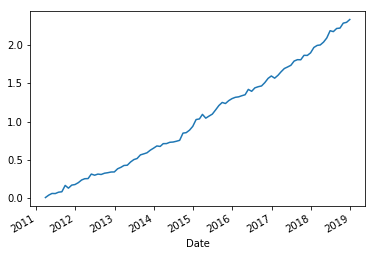

In [947]:
#plotting cumulative returns
import matplotlib.pyplot as plt
cumRet = ((1+rets).cumprod()-1)
cumRet.plot()

In [ ]:
#Calcualate annualised average return for this strategy
#Investigate rebalancing
#Simulate - does this hold for daily trading?
#Generalise for all portfolio combinations